# Load CSV File into Dataframe

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,6)})
%matplotlib inline
df = pd.read_csv('/content/drive/MyDrive/FDP Visualisation/monthly_temperature_aomori_city.csv')
df['DATE'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
df['temperature'] = df['temperature']*(9/5)+32
df.set_index('DATE',inplace=True)
df.to_csv('./monthly_temperature_aomori_city_updt.csv',index=True)
df.head()

,year,month,temperature
DATE,,,
1882-01-01,1882,1,31.28
1882-02-01,1882,2,30.92
1882-03-01,1882,3,34.16
1882-04-01,1882,4,48.02
1882-05-01,1882,5,53.78


## Data Analysis and Visualization

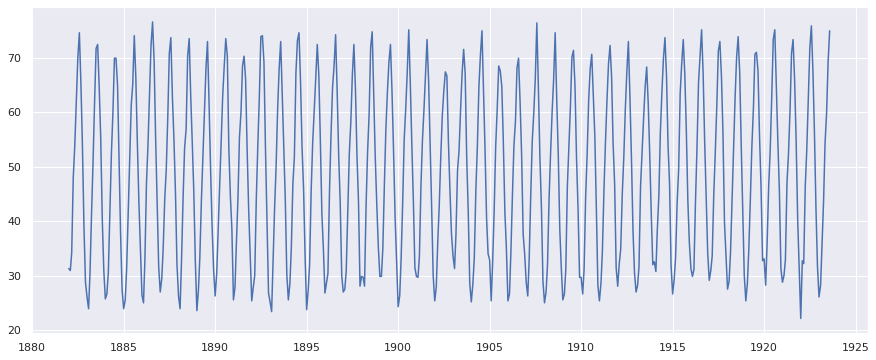

In [7]:
plt.figure(figsize=(15,6))
plt.plot(df[:500].temperature)

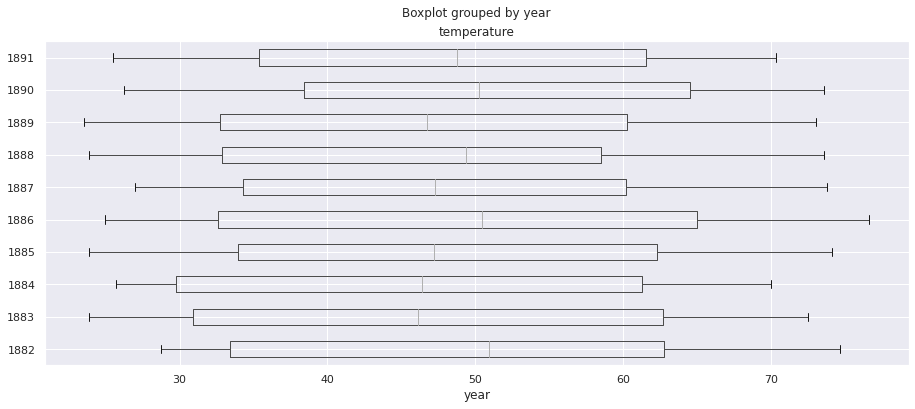

In [8]:
df[:120].boxplot(figsize=(15,6),by='year',column='temperature',vert=False)
df.drop(['year','month'],inplace=True,axis=1)

## Data Decomposition

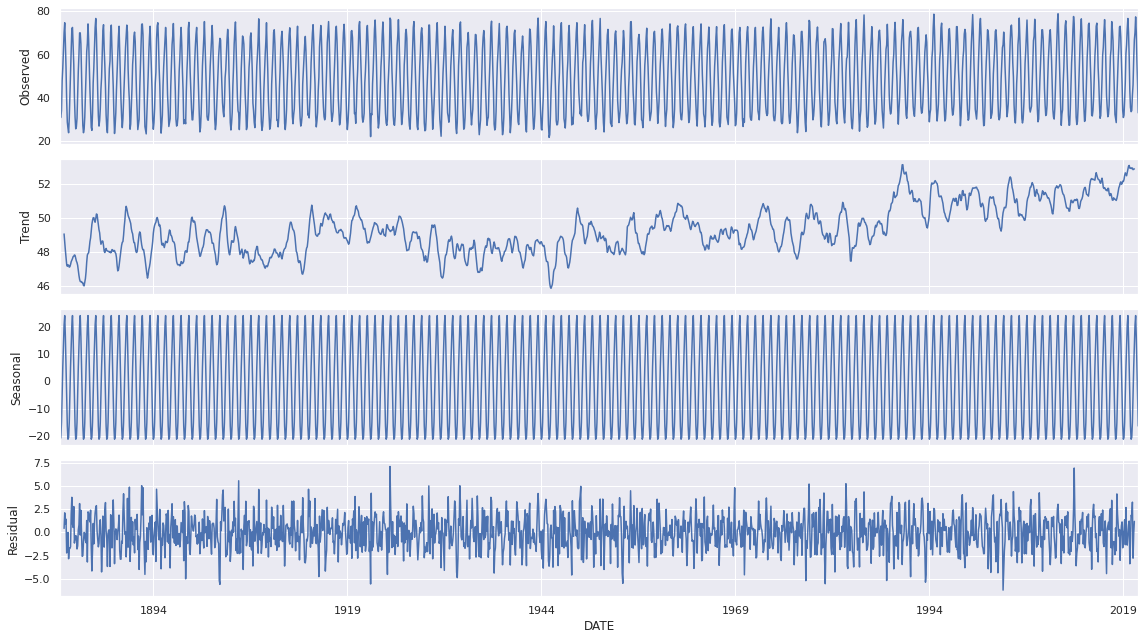

In [9]:
decomposition = sm.tsa.seasonal_decompose(df.temperature, model='additive')
plt.rcParams["figure.figsize"] = [16,9]
fig = decomposition.plot()

## Check Data Stationarity

In [10]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(timeseries):    
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [11]:
check_stationarity(df.temperature)

The test statistic: -2.806701
p-value: 0.057323
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


## Log Transformation

In [12]:
import numpy as np
ts_temp_log = np.log(df)
ts_temp_log

,temperature
DATE,
1882-01-01,3.442979
1882-02-01,3.431403
1882-03-01,3.531055
1882-04-01,3.871618
1882-05-01,3.984902
...,...
2020-08-01,4.348470
2020-09-01,4.253341
2020-10-01,4.037068


## Data Difference - To determine value of d

In [13]:
np.diff(ts_temp_log.temperature)

array([-0.01157569,  0.09965215,  0.34056222, ..., -0.21627213,
       -0.19976904, -0.33837059])

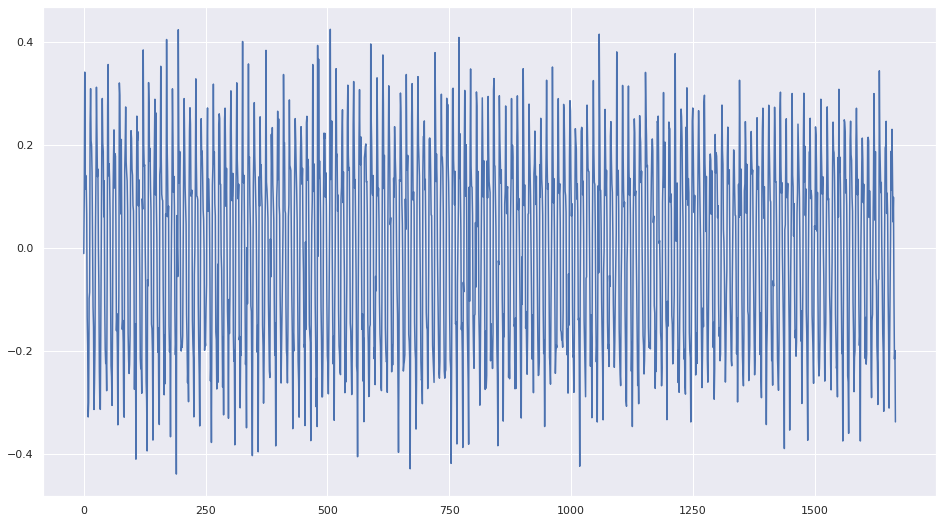

In [14]:
# Plot Data Difference to check stationary
ts_temp_log_diff = np.diff(ts_temp_log.temperature)
plt.plot(ts_temp_log_diff)

In [15]:
# Check Stationarity
check_stationarity(ts_temp_log_diff)

The test statistic: -15.766897
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


## Plot ACF and PACF

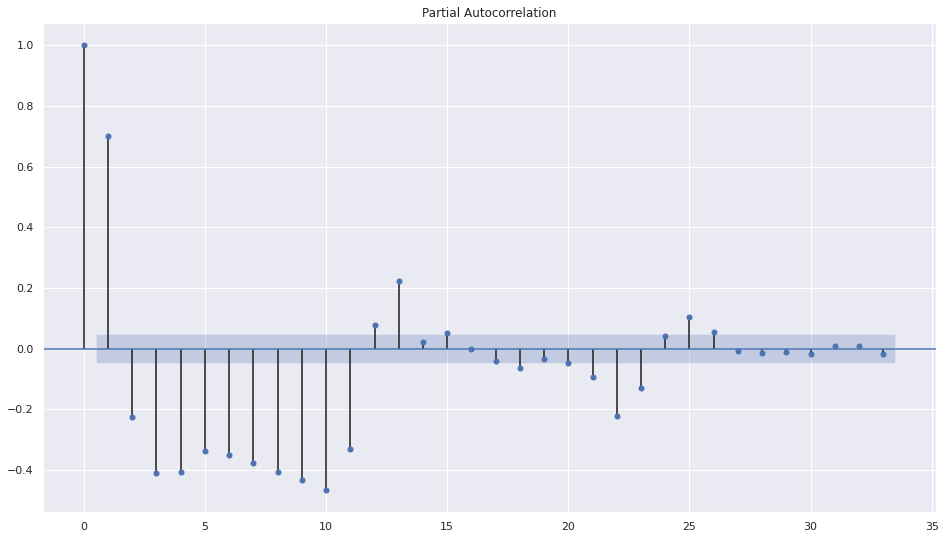

<Figure size 720x144 with 0 Axes>

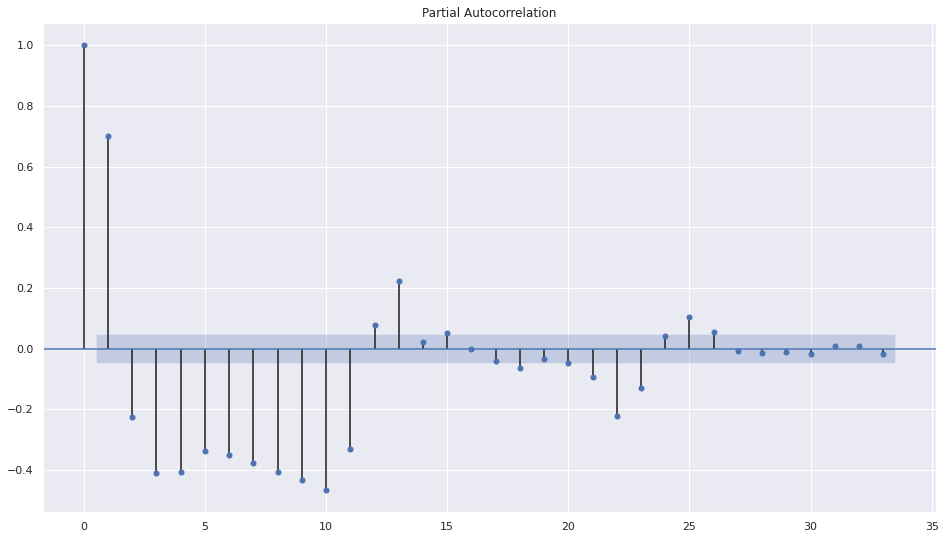

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(10,2))
plot_pacf(ts_temp_log_diff)

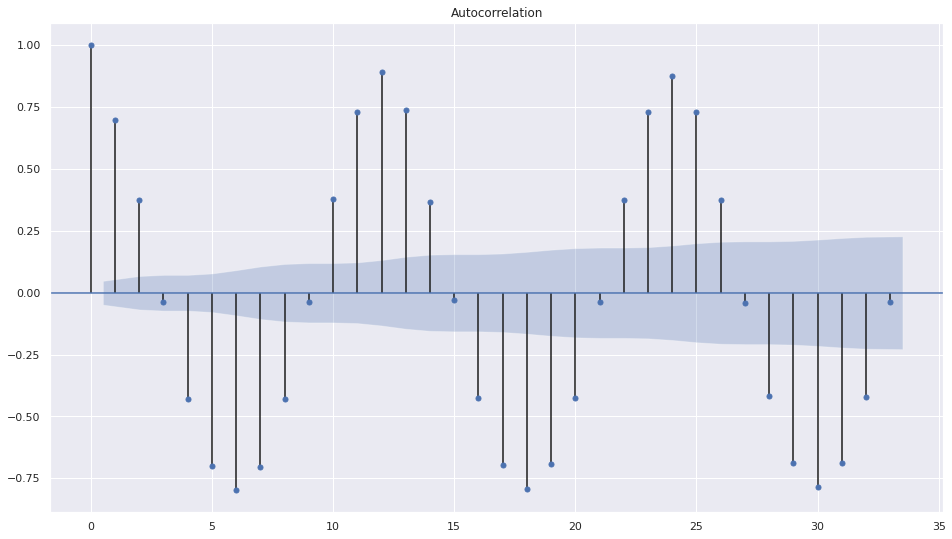

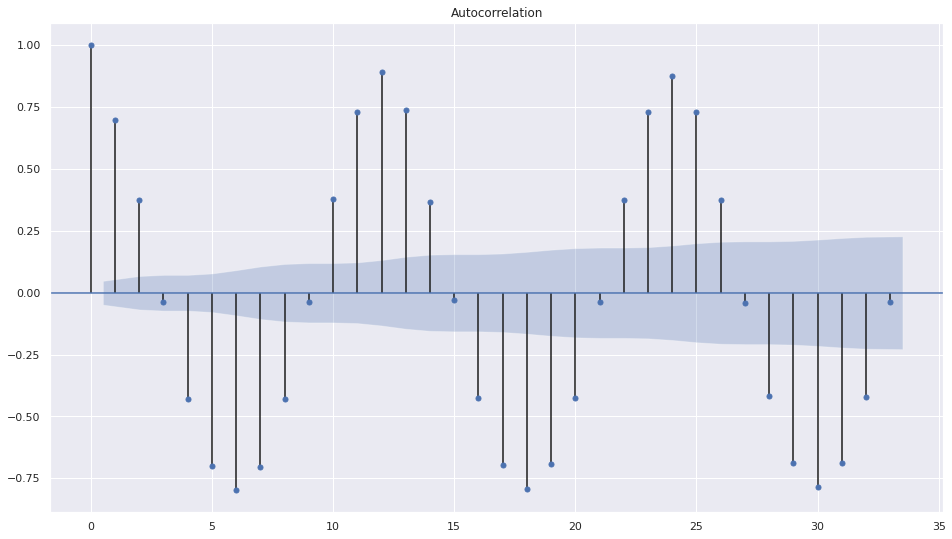

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts_temp_log_diff)

## Fitting an ARMA Model First

In [18]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(df.temperature, (3, 3)).fit()
model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            temperature   No. Observations:                 1668
Model:                     ARMA(3, 3)   Log Likelihood               -3926.764
Method:                       css-mle   S.D. of innovations              2.523
Date:                Thu, 20 May 2021   AIC                           7869.529
Time:                        18:01:04   BIC                           7912.884
Sample:                    01-01-1882   HQIC                          7885.594
                         - 12-01-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                49.3865        nan        nan        nan         nan         nan
ar.L1.temperature     1.7967        nan        nan        nan         nan         nan
ar.L2.temperature    -1.1121   2.97e-06  -3.74e+05      0.000      -1.112      -1.112
ar.L3.temperature     0.0647   5.39e-07    1.2e+05      0.000       0.065       0.065
ma.L1.temperature    -1.3070      0.027    -48.429      0.000      -1.360      -1.254
ma.L2.temperature     0.3011      0.040      7.573      0.000       0.223       0.379
ma.L3.temperature     0.3789      0.023     16.791      0.000       0.335       0.423
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8660           -0.5001j            1.0000           -0.0833
AR.2            0.8660           +0.5001j            1.0000            0.0833
AR.3           15.4556           -0.0000j           15.4556           -0.0000
MA.1            0.8786           -0.5122j            1.0170           -0.0840
MA.2            0.8786           +0.5122j            1.0170            0.0840
MA.3           -2.5519           -0.0000j            2.5519           -0.5000
-----------------------------------------------------------------------------
"""

## ARMA Residual Plot

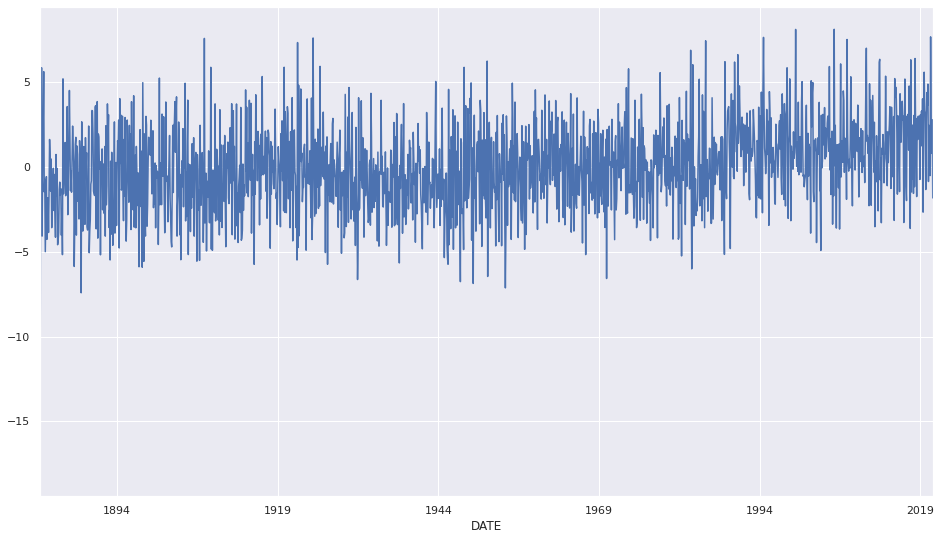

In [19]:
model.resid.plot()

## ARMA Predict vs Expected

In [ ]:
model.plot_predict(1, 30)
plt.show()

## Forecasting using ARMA forecast function

In [20]:
n=36
forecast,err,ci = model.forecast(steps=n)

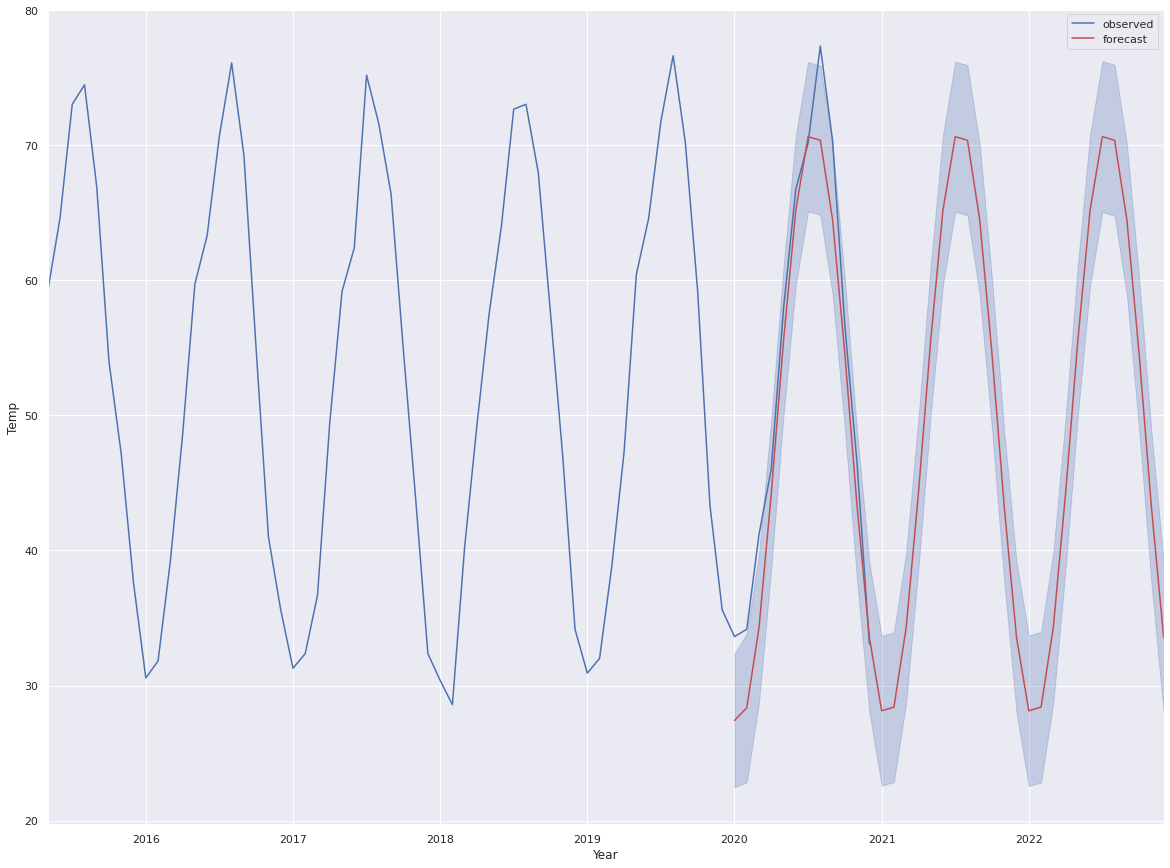

In [21]:
df_forecast = pd.DataFrame({'forecast':forecast},index=pd.date_range(start='1/1/2020', periods=n, freq='MS'))
ax = df[1600:].temperature.plot(label='observed', figsize=(20, 15))
df_forecast.plot(ax=ax,label='Forecast',color='r')
ax.fill_between(df_forecast.index,
                ci[:,0],
                ci[:,1], color='b', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Temp')

plt.legend()
plt.show()

## Fitting ARIMA Model

In [22]:
from statsmodels.tsa.arima_model import ARIMA
mod = ARIMA(df.temperature,order=(6,0,5))
results = mod.fit()
print(results.aic,results.bic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


7681.925492169482 7752.377439747425


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## Residual Analysis

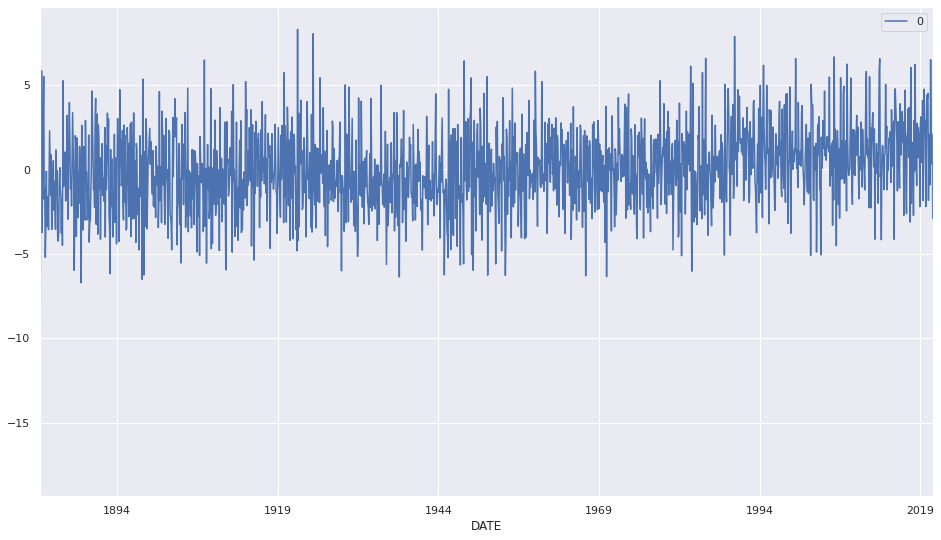

In [23]:
# Residual Plot
residuals = pd.DataFrame(results.resid)
residuals.plot()

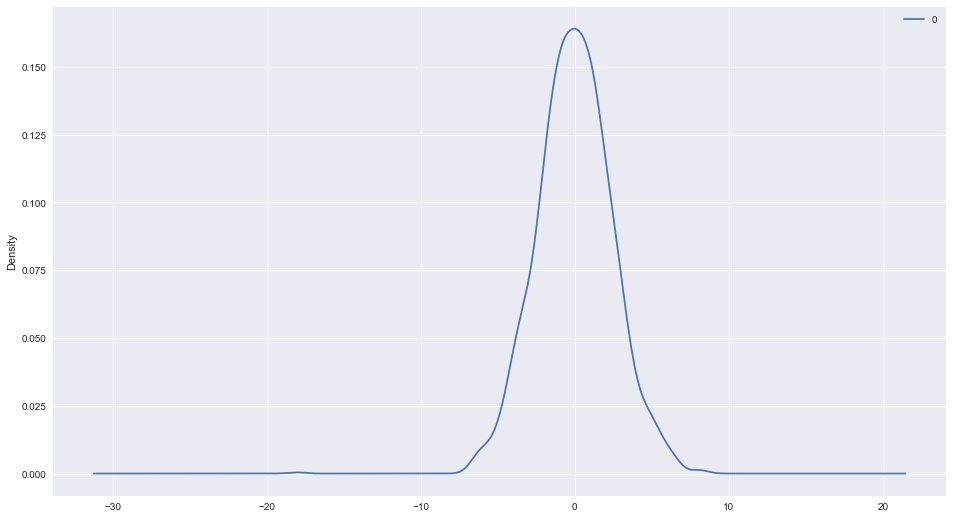

In [ ]:
# Residual Density Plot 
residuals.plot(kind='kde')

In [24]:
from statsmodels.stats.diagnostic import acorr_ljungbox
tstat,pval = acorr_ljungbox(residuals)
tstat

array([2.39764002e-01, 2.39767330e-01, 1.13978207e+00, 1.76654701e+00,
       1.48292023e+01, 1.17853298e+02, 1.24453308e+02, 1.26788790e+02,
       1.27809738e+02, 1.27856401e+02, 1.38975923e+02, 2.61446564e+02,
       2.88717999e+02, 2.95523950e+02, 2.99580370e+02, 3.02585095e+02,
       3.07993557e+02, 3.91038116e+02, 4.07100161e+02, 4.08122471e+02,
       4.08668058e+02, 4.08683648e+02, 4.23847854e+02, 5.22190958e+02,
       5.41352884e+02, 5.41516970e+02, 5.41824163e+02, 5.41916497e+02,
       5.56922620e+02, 6.51957647e+02, 6.71643883e+02, 6.73373076e+02,
       6.73402107e+02, 6.73911727e+02, 6.87289813e+02, 7.86987270e+02,
       7.96207724e+02, 7.97377898e+02, 7.97423372e+02, 7.97516105e+02])

## ARIMA Predict

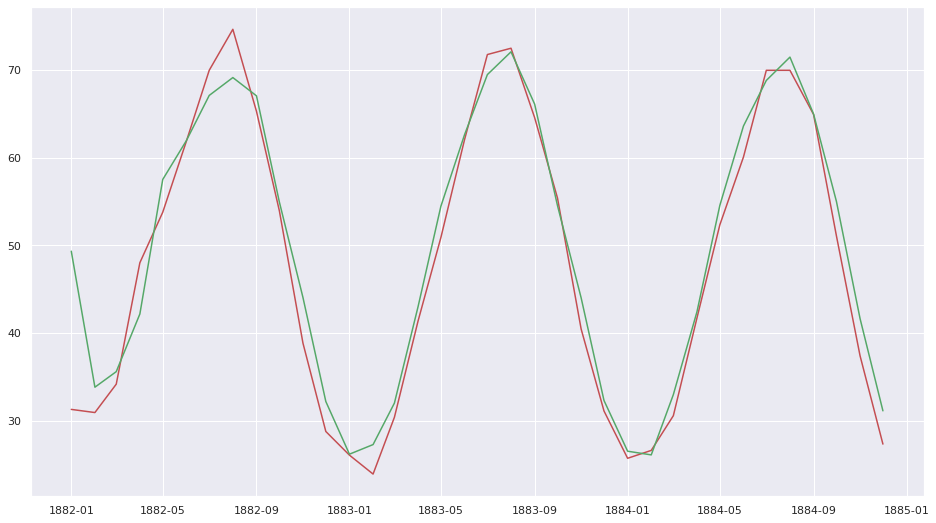

In [25]:
from math import sqrt
from sklearn.metrics import mean_squared_error
plt.plot(df.temperature[:36],color='r')
plt.plot(results.predict()[:36],color='g')

In [26]:
# Root Mean Squared Error
rmse =sqrt(mean_squared_error(df.temperature, results.predict()))
print(rmse)

2.4389645780883855


## ARIMA Forecast

In [27]:
# First 3 years i.e. from 2020 to 2023 which is 36 months
# Get forecast value, Stderr and Confidence Interval
n=36
forecast,err,ci = results.forecast(steps=n,alpha=0.05)

In [29]:
df_forecast = pd.DataFrame({'forecast':forecast},index=pd.date_range(start='1/1/2020', periods=n, freq='MS'))

In [30]:
# Checking Forecast Interval returned by forecast function
ci

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan]])

## Plot Forecast with Confidence Interval

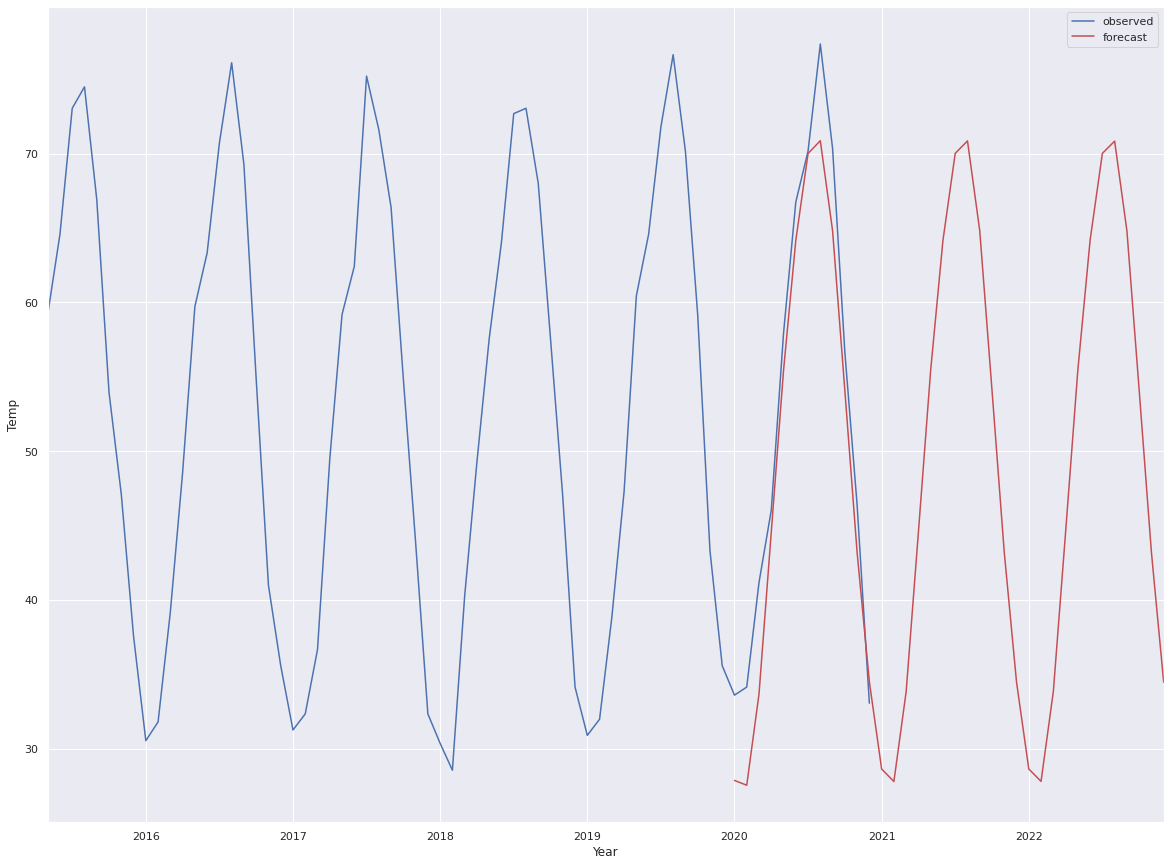

In [31]:
ax = df[1600:].temperature.plot(label='observed', figsize=(20, 15))
df_forecast.plot(ax=ax,label='Forecast',color='r')
ax.fill_between(df_forecast.index,
                ci[:,0],
                ci[:,1], color='b', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Temp')

plt.legend()
plt.show()

### Auto ARIMA

In [32]:
import pyramid as pm
stepwise_fit = pm.auto_arima(df, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True) 

ModuleNotFoundError: ignored